In [1]:
import pytraj as pt
from sklearn.cluster import KMeans
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DIR = '/hdd/si_han/GPU0/si_han/Project/Abeta/'
TRAJ='/hdd/si_han/GPU0/si_han/Project/Abeta/1us_IDPS.dcd'
TOP='/hdd/si_han/GPU0/si_han/Project/Abeta/idps_1.prmtop'

### Load Trajectory

In [3]:
traj = pt.iterload(TRAJ,TOP)
frameidx=np.array(range(traj.n_frames))
traj

pytraj.TrajectoryIterator, 10000 frames: 
Size: 0.140145 (GB)
<Topology: 627 atoms, 42 residues, 1 mols, non-PBC>
           

#### superimpose the trajectory to the refertence frame

In [4]:
pt.superpose(traj, ref=0, mask='@CA')

pytraj.TrajectoryIterator, 10000 frames: 
Size: 0.140145 (GB)
<Topology: 627 atoms, 42 residues, 1 mols, non-PBC>
           

### Cluster by RMSD of C$_\alpha$ Cartesian coodinates

#### Extract Cartesian coordinates of C$_\alpha$ atoms from "traj"

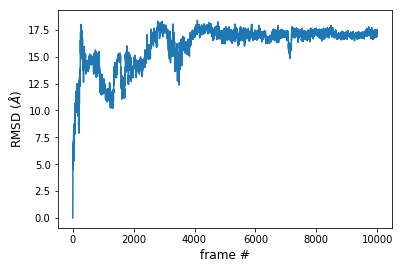

In [5]:
CA = traj['@CA'] # CA trajectory
CA_2d = CA.xyz.reshape(CA.n_frames,CA.n_atoms*3)
RMSD = pt.rmsd(CA, ref=0, nofit=True)

plt.figure()
plt.plot(range(len(RMSD)), RMSD)
plt.xlabel('frame #', fontsize = 12)
plt.ylabel('RMSD ($\AA$)', fontsize = 12)
plt.show()

#### optimize k by an elbow curve

In [6]:
Kdistant=[]
n_datas = len(CA_2d)
for k in range(1,20):
    tmp=0
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(RMSD.reshape(-1,1))
    labels = kmeans.predict(RMSD.reshape(-1,1))
    C = kmeans.cluster_centers_
    

    tmp+=np.linalg.norm(RMSD.reshape(-1,1)[labels==(k-1)] - C[(k-1)], axis=1).sum()
    Kdistant.append([k,tmp/n_datas])
Kdistant=np.array(Kdistant)

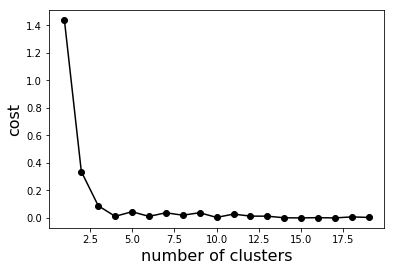

In [7]:
plt.figure()
plt.plot(Kdistant[:,0],Kdistant[:,1], marker='o', color='k')
plt.xlabel('number of clusters', fontsize=16)
plt.ylabel('cost', fontsize=16)
plt.show()

In [8]:
nc=4 # change the optimized number of clusters here according to the elbow curve
kmeans = KMeans(n_clusters=nc, init='k-means++').fit(RMSD.reshape(-1,1))
labels = kmeans.predict(RMSD.reshape(-1,1))
C = kmeans.cluster_centers_

#### Color each cluster

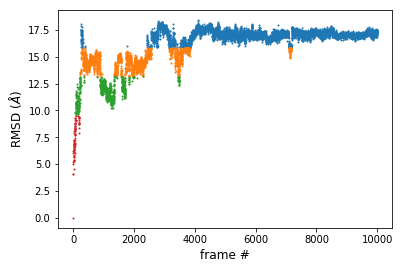

In [9]:
plt.figure()

for i in range(len(C)):
    plt.scatter(np.array(range(len(RMSD)))[labels==i], RMSD[labels==i], s=1)
plt.xlabel('frame #', fontsize = 12)
plt.ylabel('RMSD ($\AA$)', fontsize = 12)
plt.show()

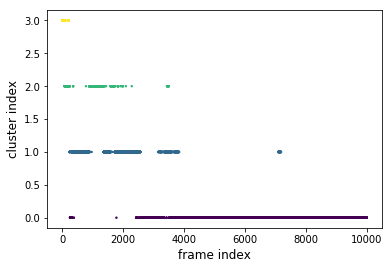

In [10]:
%matplotlib inline
plt.figure()
plt.scatter(range(len(RMSD)), labels, c= labels, s = 2)
plt.xlabel('frame index', fontsize = 12)
plt.ylabel('cluster index', fontsize = 12)
plt.show()

#### Export separate trajectories of clusters

In [11]:
Out = DIR+'RMSD_CA' # make sure you've created this ooutput folder in your computer

In [12]:
for i in range(nc):
    traj[frameidx[labels==i].tolist()].save(Out+'/rmsd_ca_%d.dcd'%(i+1), overwrite=True)
    print("cluster %d"%(i+1), "%d frames"%len(frameidx[labels==i]))

cluster 1 7083 frames
cluster 2 2042 frames
cluster 3 785 frames
cluster 4 90 frames
